In [1]:
import os

datadir = "/home/ymerel/fmri/OHBM_2026_neurovariants/data/motor_1000"
ds_path = os.path.join(datadir, 'dataset.csv')
corr_path = os.path.join(datadir, 'correlations.csv')
corr_func = 'pearson'
basedir = "/home/ymerel/storage/results/"
jobname = "motor_1000"
result_path = f"{basedir}{jobname}"
coords = [0, -4, 54]

In [2]:
!sshfs -o reconnect,ServerAliveInterval=120,ServerAliveCountMax=3 rennes.g5k:/srv/storage/empenn@storage2.rennes.grid5000.fr/private/ymerel /home/ymerel/storage

In [3]:
import pandas as pd

def normalize_dataset(ds: pd.DataFrame):
    
    str_alternatives = {
        "motion_correction_realignment/register_to" : ["first", "mean"],
        "coregistration/source_target" : ["anat_on_func", "func_on_anat"],
        "coregistration/cost_function" : ["mutual_information", "normalised_mutual_information", "entropy_correlation_coefficient", "normalised_cross_correlation"],
        "spatial_normalization/template" : ["Ixi549Space", "MNI305", "MNI152_linear", "MNI152_nonlinear"],
        "spatial_normalization/algorithm" : ["linear", "nonlinear", "DARTEL"],
        "spatial_normalization/interpolation" : ["nearest_neighbour", "trilinear", "bspline"],
        "slice_timing_correction/ref_slice" : ["first", "middle"],
        "signal_modeling/hrf" : ["canonical", "temporal_derivs", "temporal_dispersion_derivs"],
        "signal_modelling/temporal_noise_autocorrelation" : ["AR1", "FAST"],
    }

    num_alternatives = {
        "spatial_normalization/bias_fwhm" : [30, 40, 60, 70, 80, 90, 100, 110, 120,130,140,150],
        "spatial_smoothing/fwhm" : [2, 4, 6, 8, 10, 12, 14],
        "signal_modeling/nuisance_regressors/motion" : [6, 18, 24]
    }
    
    bias_regs = {
            'extremely_light': 0.00001,
            'very_light': 0.0001,
            'light': 0.001,
            'medium': 0.01,
            'heavy': 0.1
        }
    
    # change column types
    for col in num_alternatives:
        ds[col] = ds[col].astype(int)
    for col in bias_regs:
        ds[f"spatial_normalization/bias_regularisation/{col}"] = ds[f"spatial_normalization/bias_regularisation/{col}"].astype(float)
    
    for index, row in ds.iterrows():
        for feature, values in num_alternatives.items():
            if row[feature] is False:
                ds.at[index, feature] = 0
                continue
            for val in values:
                alt = f"{feature}/{val}"
                if row[alt] is True:
                    ds.at[index, feature] = val
        for label, value in bias_regs.items():
            if row[f"spatial_normalization/bias_regularisation/{label}"] is True:
                ds.at[index, "spatial_normalization/bias_regularisation"] = value
    
    for key in num_alternatives:
        for val in num_alternatives[key]:
            ds = ds.drop(f"{key}/{val}",  axis=1)
    ds = ds.convert_dtypes()
    boolean_columns = ds.select_dtypes(include='bool').columns
    columns_to_drop = [col for col in boolean_columns if ds[col].all()]
    columns_to_drop.append("pearson_from_mean")
    columns_to_drop.append("spearman_from_mean")
    columns_to_drop.append("spearman_from_ref")
    ds = ds.drop(columns=columns_to_drop)
    ds.rename(columns={f'{corr_func}_from_ref': 'from_ref'}, inplace=True)
    return ds

# Load data

In [4]:
# load correlations
correlations = pd.read_csv(corr_path, delimiter=';')
print(len(correlations))
matrix = correlations.pivot(index='source', columns='target', values=corr_func).fillna(1.0)
distance_matrix = 1 - matrix

dataset = pd.read_csv(ds_path, delimiter=';')
dataset = normalize_dataset(dataset)

dataset.head(1010)

1004004


,coregistration/source_target/func_on_anat,signal_modeling/nuisance_regressors,motion_correction_realignment/register_to/mean,coregistration/cost_function/normalised_mutual_information,motion_correction_realignment/register_to/first,signal_modelling/temporal_noise_autocorrelation/FAST,spatial_normalization/template/MNI152_linear,spatial_normalization/interpolation/trilinear,spatial_normalization/template/MNI305,spatial_normalization/algorithm/linear,...,slice_timing_correction/tool,spatial_normalization/interpolation/bspline,spatial_normalization/bias_regularisation/heavy,slice_timing_correction,slice_timing_correction/tool/spm,slice_timing_correction/ref_slice/first,coregistration/source_target/anat_on_func,spatial_normalization/template/MNI152_nonlinear,id,from_ref
0,False,True,True,True,False,False,False,False,False,False,...,True,True,0,True,True,False,True,False,3c05066eec67a15033be163c0f9ff11b5c10fd45cd65ba...,0.885294
1,True,False,True,False,False,False,False,False,False,False,...,True,True,0,True,True,True,False,False,893964ab30cc3576a3e67365258d83dbf1004113959bb6...,0.26272
2,True,False,True,False,False,True,False,False,False,False,...,True,True,0,True,True,True,False,False,5e8fa80e524e2318384b2a43c6d7aa95a1715d7b2d9bb5...,0.26272
3,True,True,True,False,False,False,False,False,False,False,...,False,False,0,False,False,False,False,False,929c564906b972a8e5ff01a5c75b2fb5d5d326e9a99a19...,0.287721
4,False,True,True,True,False,False,False,True,False,False,...,True,False,0,True,True,True,True,False,6a45076ef4e7d5e2e19b1eff4c2400f12820aff5f5de35...,0.971575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,True,False,False,False,False,False,...,True,True,0,True,True,True,True,False,b113529b25ad5d523e71aa871814dd6488422ed4e99bcd...,0.783645
996,False,True,True,False,False,False,False,True,False,False,...,True,False,0,True,True,True,True,False,b37758404e40f9dea67fbd21cea525377ab19ba18e09af...,0.839318
997,True,False,True,False,False,True,False,True,False,False,...,True,False,0,True,True,True,False,False,3401ad490c00a92496523f27be5d4b91a49a4b7cc77c5d...,0.259678
998,False,False,True,False,False,False,False,False,False,False,...,False,False,0,False,False,False,True,False,411c43eb0a73f49a676d3a0b79ce54efe04a0ade465c92...,0.792962


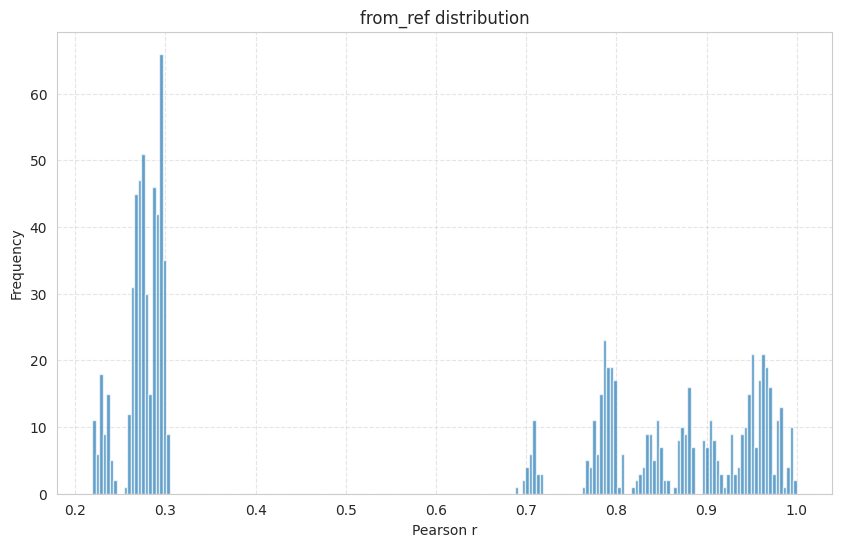

/home/ymerel/tmp/ipykernel_16048/3804470831.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sb.kdeplot(dataset['from_ref'], shade=True, color='blue')


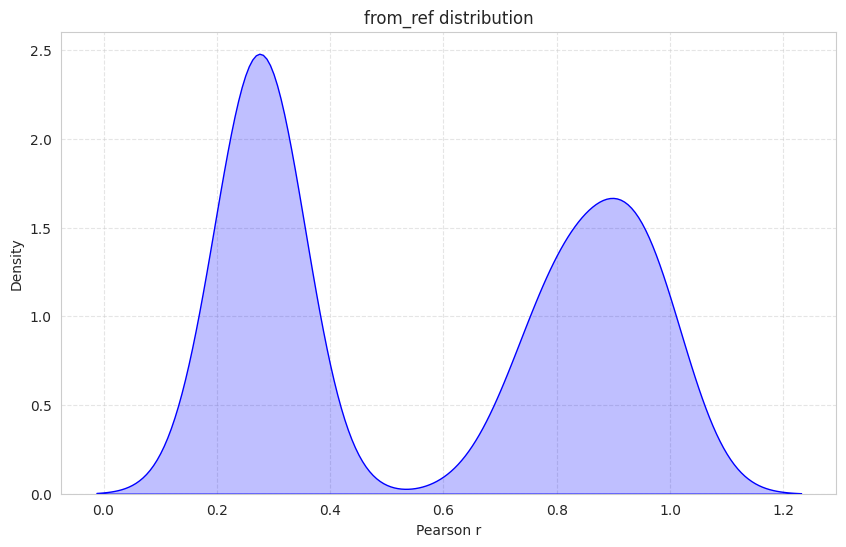

In [13]:
import seaborn as sb
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(dataset['from_ref'], bins=200, alpha=0.7)
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

plt.figure(figsize=(10, 6))
sb.kdeplot(dataset['from_ref'], shade=True, color='blue')
plt.title('from_ref distribution')
plt.xlabel('Pearson r')
plt.ylabel('Density')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Compare correlations metrics
Evaluate distribution of values for Pearson, spearman, jaccard, dice
Compare Pearson vs Spearman

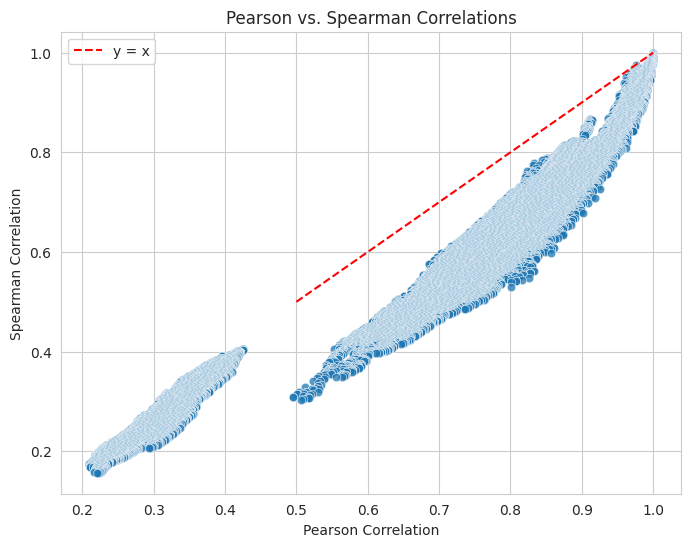

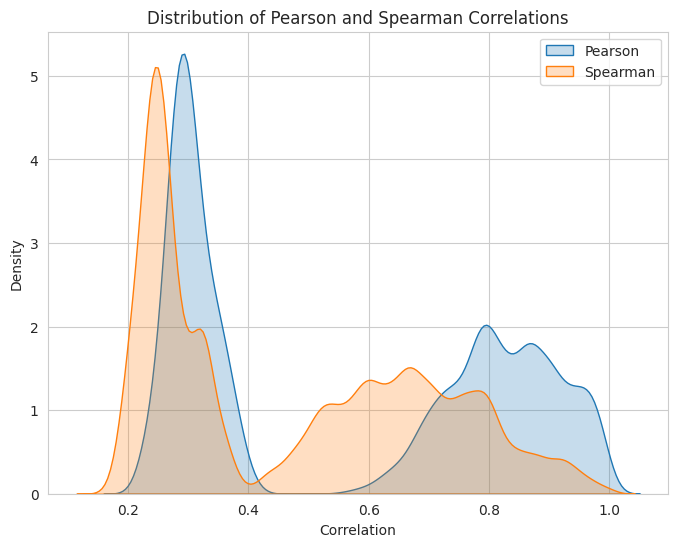

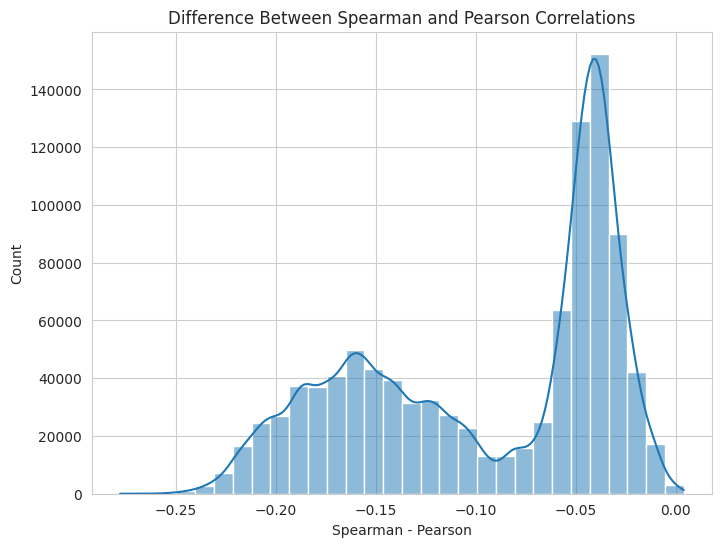

In [15]:
import matplotlib.pyplot as plt
import seaborn as sb

plt.figure(figsize=(8, 6))
sb.scatterplot(data=correlations, x="pearson", y="spearman", alpha=0.5)
plt.plot([0.5, 1], [0.5, 1], 'r--', label="y = x")  # Diagonal line
plt.xlabel("Pearson Correlation")
plt.ylabel("Spearman Correlation")
plt.title("Pearson vs. Spearman Correlations")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
sb.kdeplot(data=correlations, x="pearson", label="Pearson", fill=True)
sb.kdeplot(data=correlations, x="spearman", label="Spearman", fill=True)
plt.xlabel("Correlation")
plt.ylabel("Density")
plt.title("Distribution of Pearson and Spearman Correlations")
plt.legend()
plt.show()

correlations["difference"] = correlations["spearman"] - correlations["pearson"]

plt.figure(figsize=(8, 6))
sb.histplot(data=correlations, x="difference", bins=30, kde=True)
plt.xlabel("Spearman - Pearson")
plt.ylabel("Count")
plt.title("Difference Between Spearman and Pearson Correlations")
plt.show()

# Clusterize

## Cluster by threshold

In [16]:
from utils import clusterize_hierch, predict_clusters, get_cluster_distance_densities, get_cluster_cophenetic,get_cluster_silhouette, get_cluster_inertia, get_davies_bouldin, get_medoids, get_antimedoids
import numpy as np

all_results = []

thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values))
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
    results['antimedoids'] = get_antimedoids(distance_matrix, clusters)
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)
df_by_thresh = pd.DataFrame(all_results)

/home/ymerel/fmri/OHBM_2026_neurovariants/utils.py:110: RuntimeWarning: invalid value encountered in scalar divide
  avg_dist = (np.sum(cluster_dist) - np.sum(np.diag(cluster_dist))) / (cluster_dist.size - len(cluster_dist))


## Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

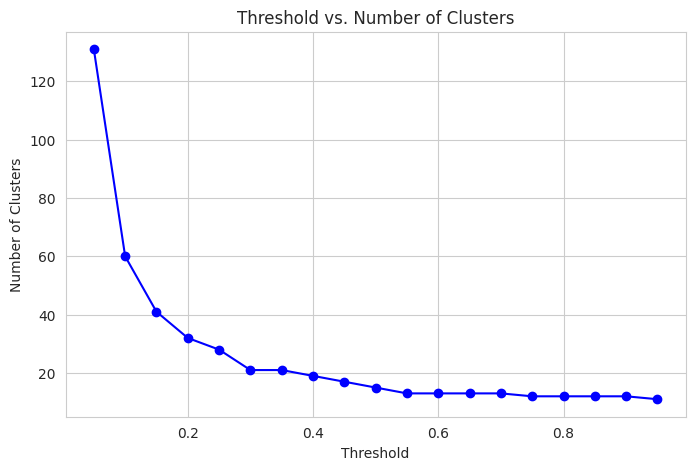

,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,antimedoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,131,NaN,0.982074,0.512496,1.141242,1.856483,{56: '9c756178b3bce44a5135ae863ee2bfab7d25c4fa...,{56: 'ad3c88012215748c589b7d8cf09a7865b2e84f6d...,0.7,0.793333,0.708699,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
1,0.10,60,0.022537,0.982074,0.481384,1.088726,11.130841,{31: '9c756178b3bce44a5135ae863ee2bfab7d25c4fa...,{31: '86058ea84bd19ebe298f9704a30ae52e59ba29e1...,0.7,0.963333,0.944558,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
2,0.15,41,0.027183,0.982074,0.531628,1.083757,24.809942,{21: '9c756178b3bce44a5135ae863ee2bfab7d25c4fa...,{21: '86058ea84bd19ebe298f9704a30ae52e59ba29e1...,0.7,0.983333,0.970208,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
3,0.20,32,0.031520,0.982074,0.573884,1.009385,43.558904,{14: '95b8fdfb3a66db922a7f3a9e0d261f924c896078...,{14: '74d0522ae1970fb0c4869f6366caf5425c693dbe...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
4,0.25,28,0.033981,0.982074,0.552165,0.973019,57.015950,{12: '95b8fdfb3a66db922a7f3a9e0d261f924c896078...,{12: '74d0522ae1970fb0c4869f6366caf5425c693dbe...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
5,0.30,21,0.037889,0.982074,0.570579,0.741191,94.692608,{10: '95b8fdfb3a66db922a7f3a9e0d261f924c896078...,{10: '74d0522ae1970fb0c4869f6366caf5425c693dbe...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
6,0.35,21,0.037889,0.982074,0.570579,0.741191,94.692608,{10: '95b8fdfb3a66db922a7f3a9e0d261f924c896078...,{10: '74d0522ae1970fb0c4869f6366caf5425c693dbe...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
7,0.40,19,0.039669,0.982074,0.573852,0.701776,139.783661,{8: '95b8fdfb3a66db922a7f3a9e0d261f924c8960780...,{8: '74d0522ae1970fb0c4869f6366caf5425c693dbee...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
8,0.45,17,0.044013,0.982074,0.568366,0.711042,165.007010,{8: '95b8fdfb3a66db922a7f3a9e0d261f924c8960780...,{8: '74d0522ae1970fb0c4869f6366caf5425c693dbee...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...
9,0.50,15,0.049710,0.982074,0.590100,0.714868,243.708502,{7: '95b8fdfb3a66db922a7f3a9e0d261f924c8960780...,{7: '74d0522ae1970fb0c4869f6366caf5425c693dbee...,0.7,1.000000,1.000000,"digraph Tree {\nnode [shape=box, style=""filled...",{'coregistration/source_target/func_on_anat': ...


In [17]:
df_results = df_by_thresh
plt.figure(figsize=(8, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b')
plt.title('Threshold vs. Number of Clusters')
plt.xlabel('Threshold')
plt.ylabel('Number of Clusters')
plt.grid(True)
plt.show()
df_results.head(20)

## Identify incorrect clusters by medoids

Cluster [1] - Medoid [9111a94c1a55f876b2a92dfa6466af0879e5b3487240c5ebf816502c3366b1d5]


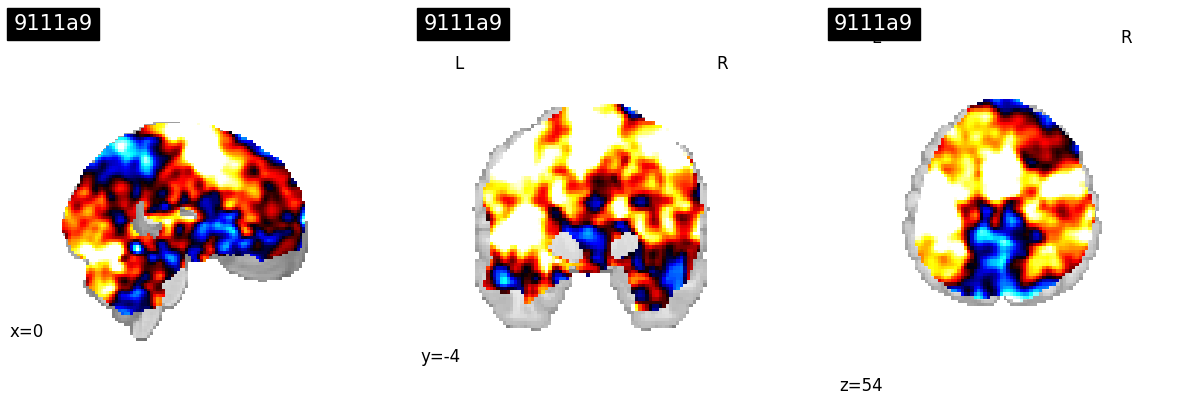

Cluster [1] - Antimedoid


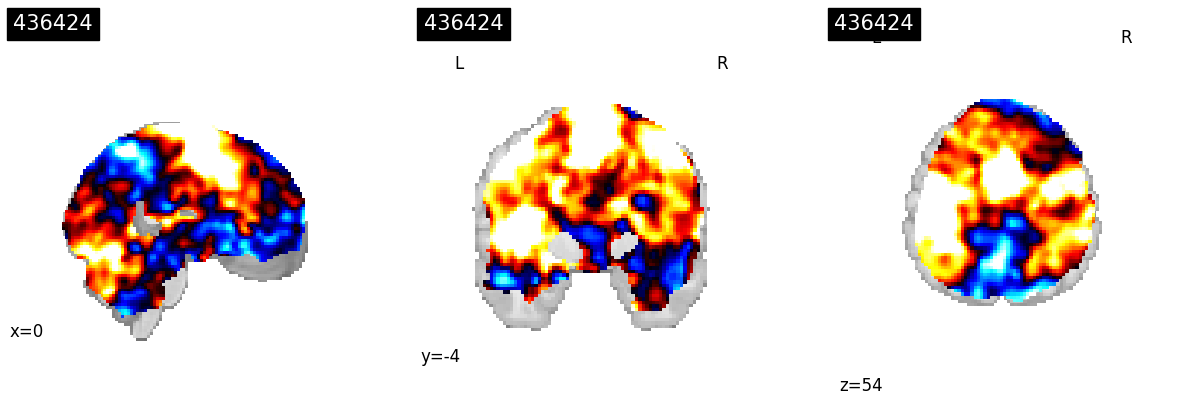

Cluster [2] - Medoid [389ad782a09c22f9e9028ce8f4cc2d6a84301e27847d742e6b31073466cedde6]


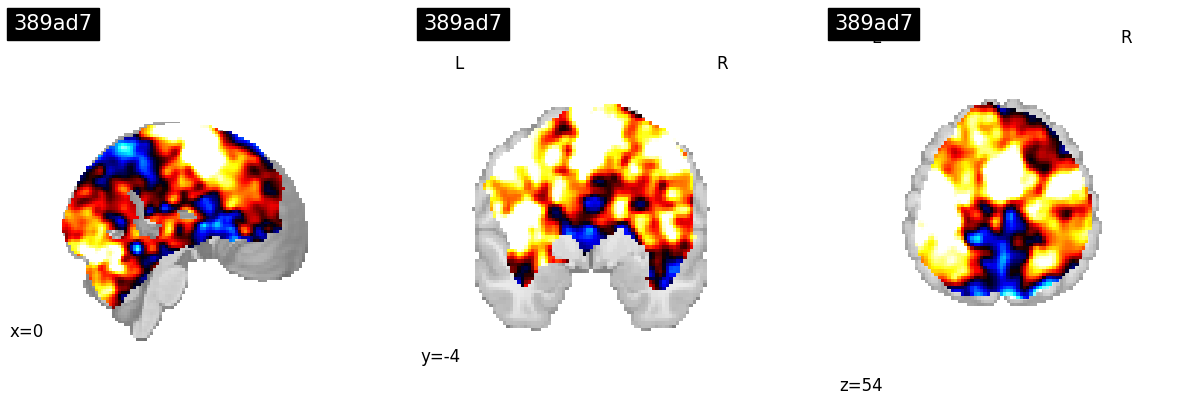

Cluster [2] - Antimedoid


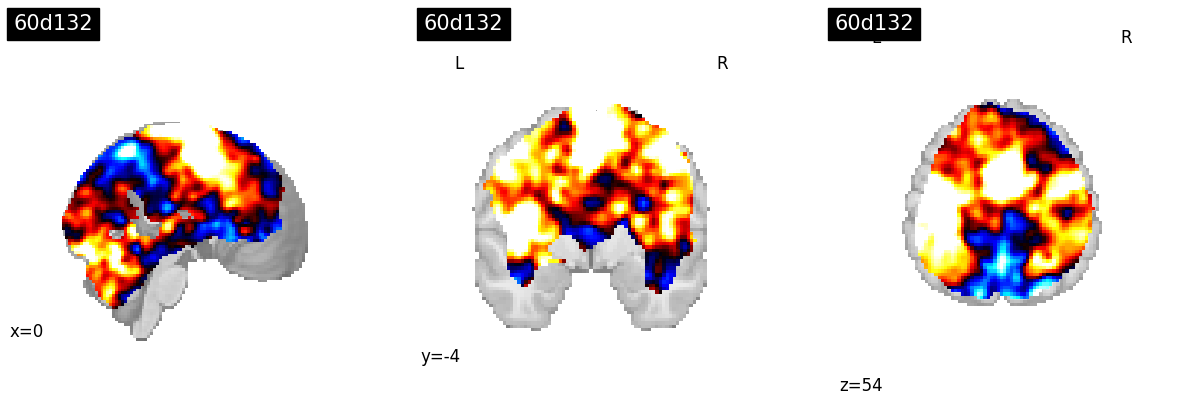

Cluster [3] - Medoid [d30bed88c1058d2171217b1222a38a46647a46564e3f4678695f911aec4598eb]


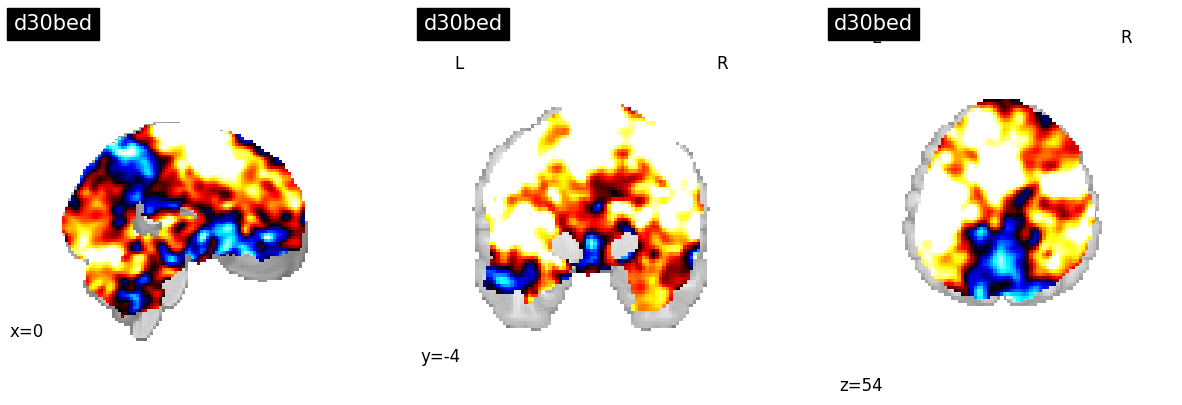

Cluster [3] - Antimedoid


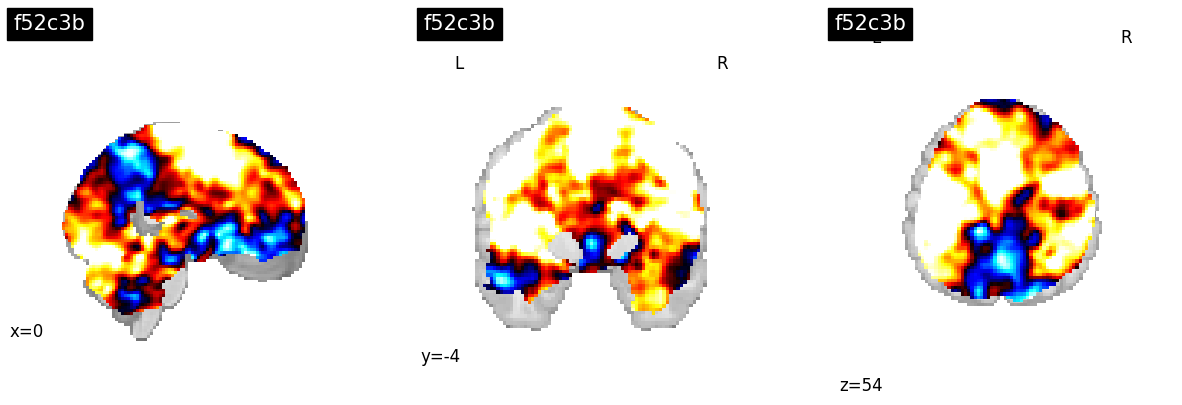

Cluster [4] - Medoid [71e407ecf3e4c3b45941b22394d693b9dbbaa03f7d21f1e90fc4482415cac5c5]


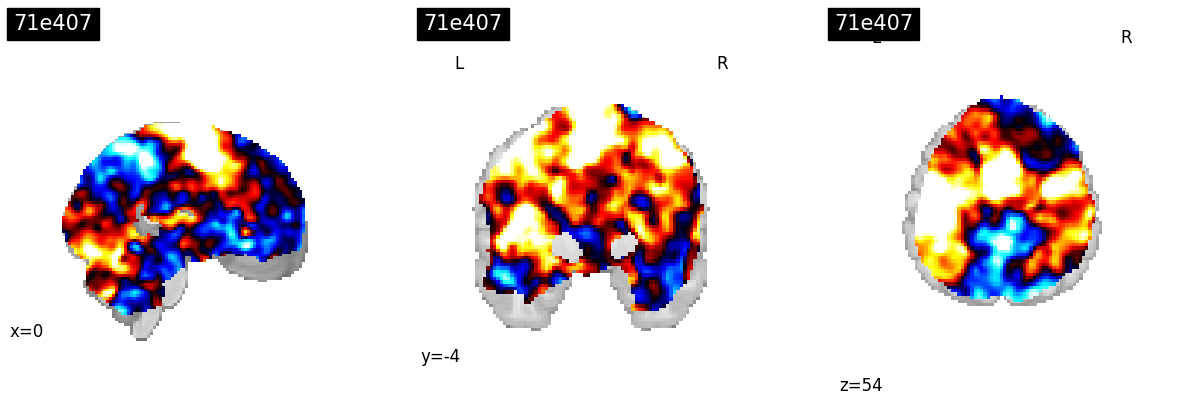

Cluster [4] - Antimedoid


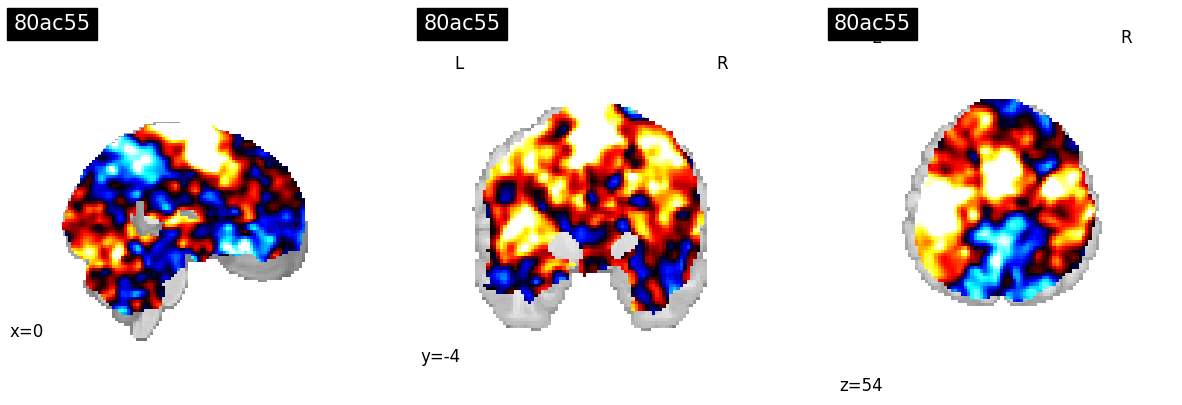

Cluster [5] - Medoid [ada36a24db840f58218d978664733af9218be6f13a616d70188432ed4c811efb]


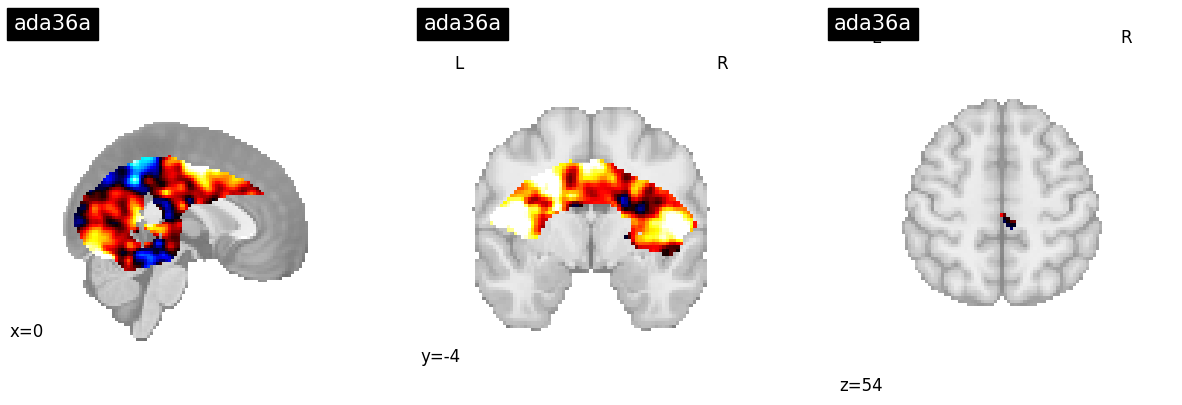

Cluster [5] - Antimedoid


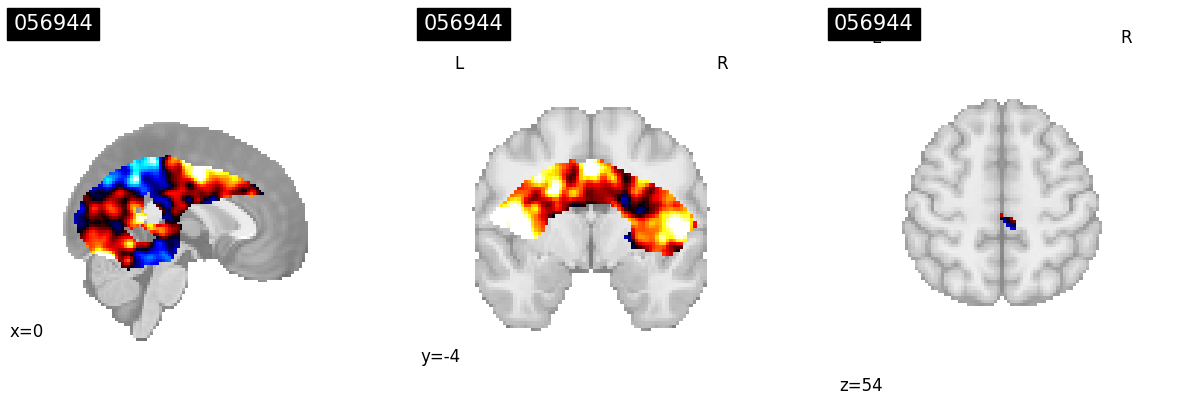

Cluster [6] - Medoid [95b8fdfb3a66db922a7f3a9e0d261f924c89607800af9f307453c37284979879]


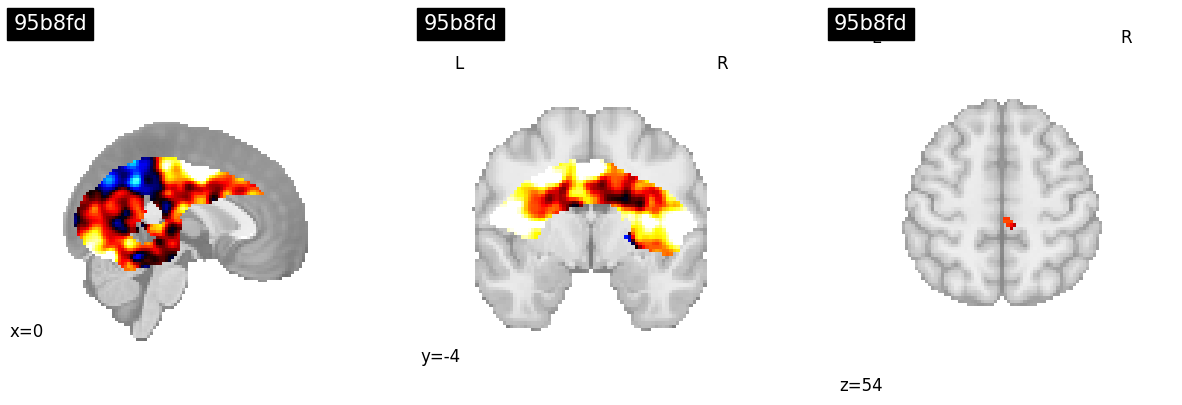

Cluster [6] - Antimedoid


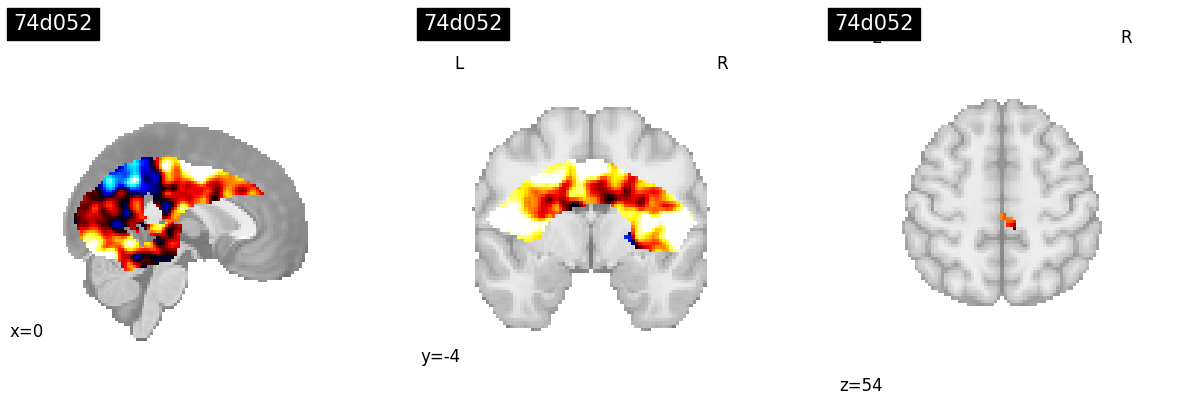

Cluster [7] - Medoid [0299dc9e279b6d0a5010792b7eccf32060d171f94d6dde8285c4e426cfe357e2]


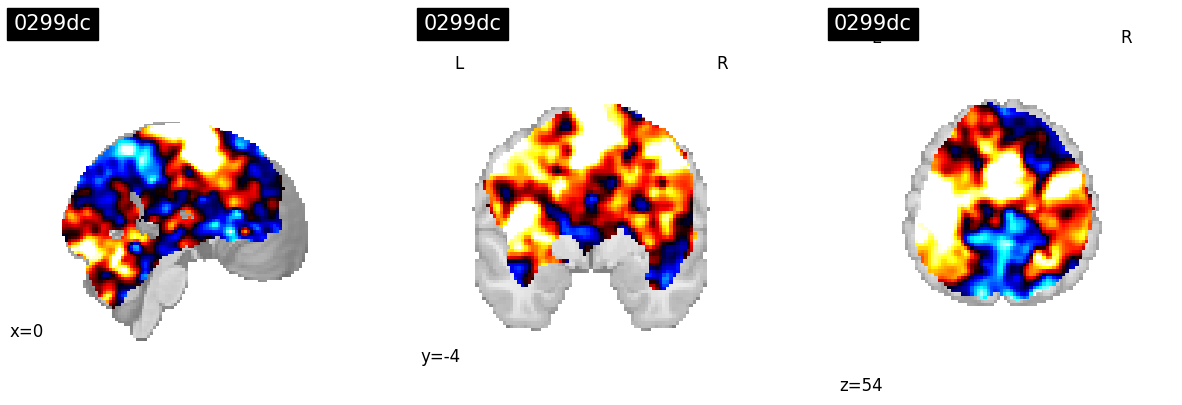

Cluster [7] - Antimedoid


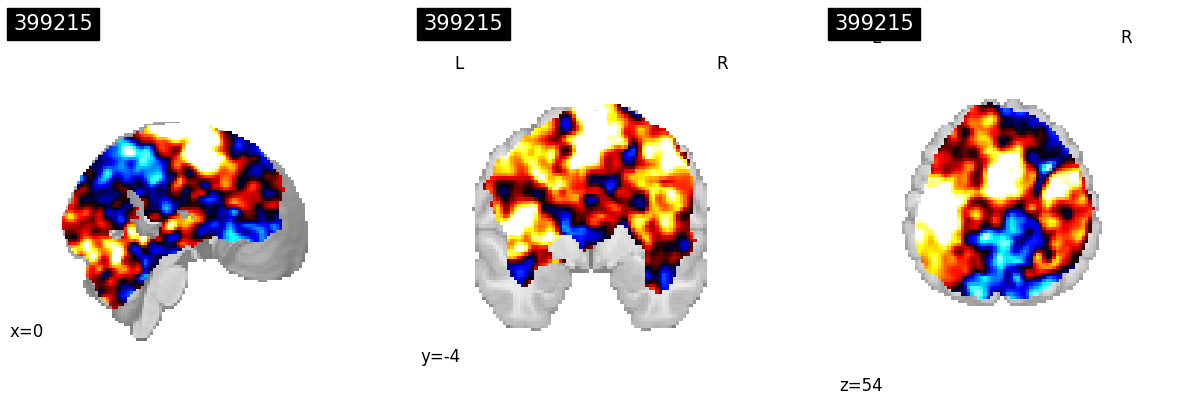

Cluster [8] - Medoid [b167b97f4dda778f5d683f913d9a078cb98218a42084e826c6336d58bc203322]


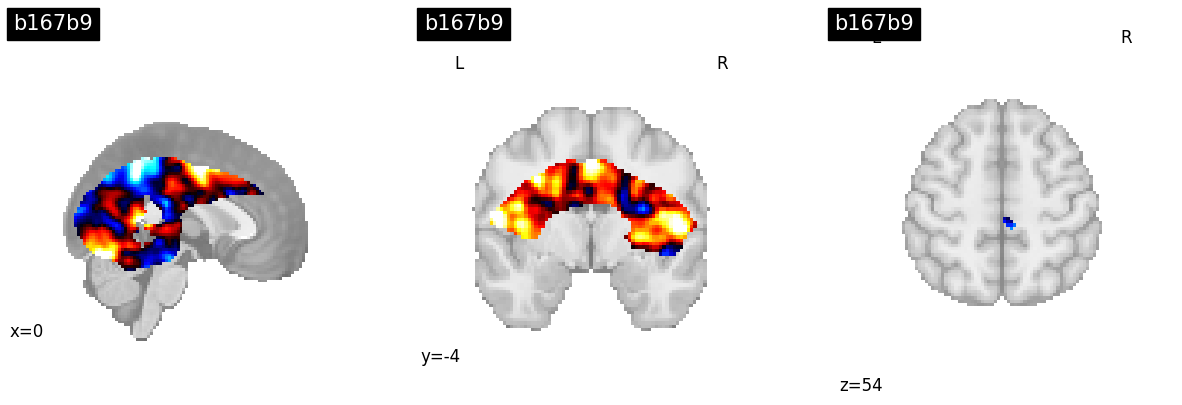

Cluster [8] - Antimedoid


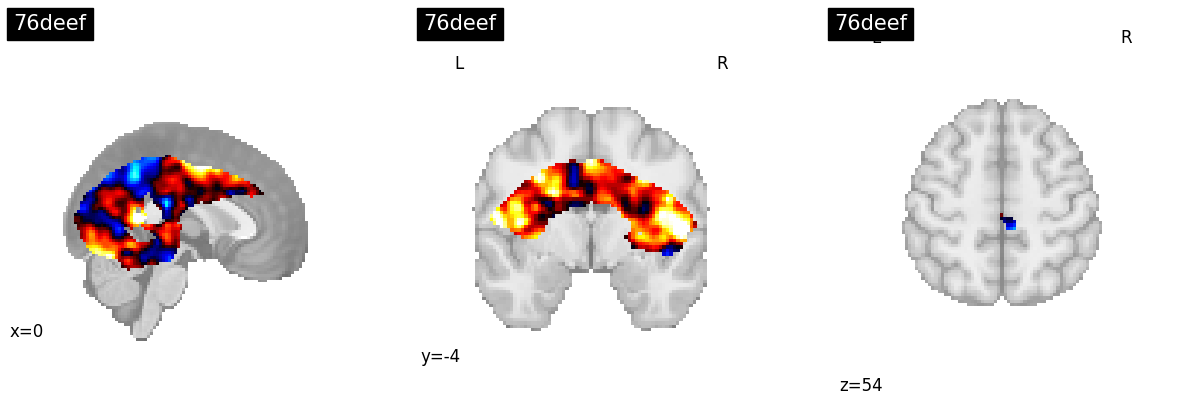

Cluster [9] - Medoid [4c2b602c453984c65a4c7e70e53304b9812ea4f480eac8a053d45902f805ac76]


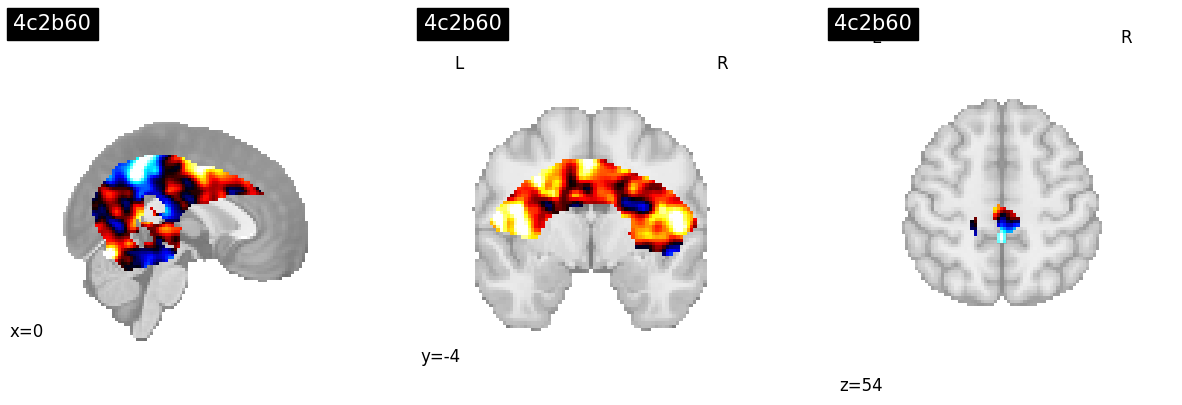

Cluster [9] - Antimedoid


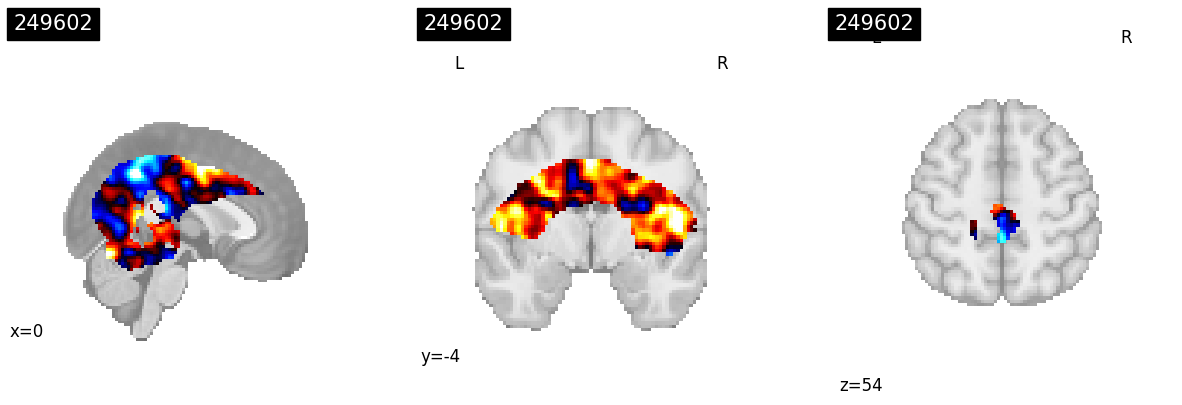

Cluster [10] - Medoid [0fd2a2e588c8a5a439f18a27b00e8614cf37fd1f2d0012d4255b5d6a7b586de4]


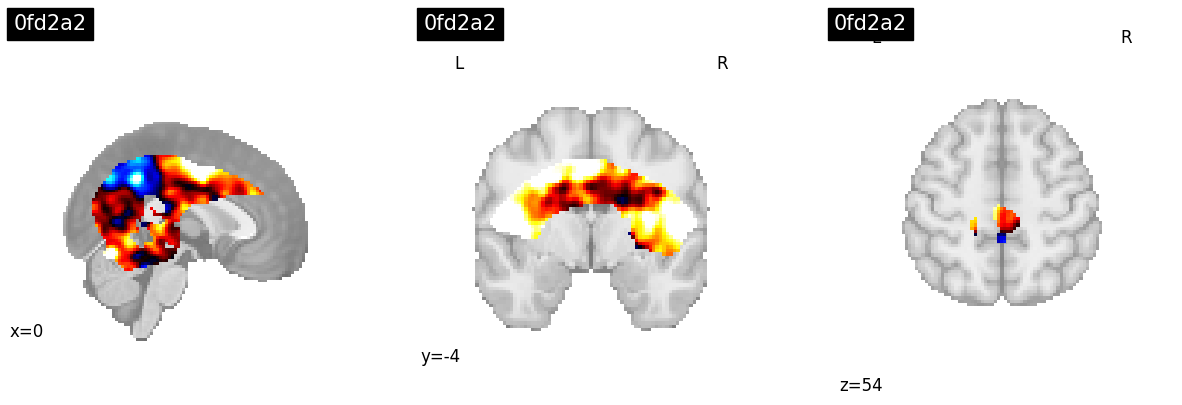

Cluster [10] - Antimedoid


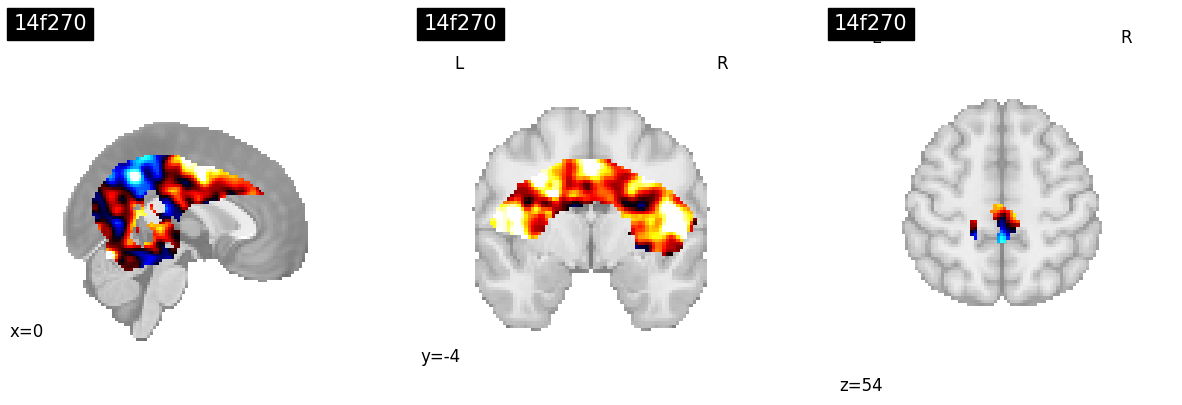

Cluster [11] - Medoid [5eeea1db962fc4a220da6ce65d65c466663ec97f0353102c40295446074a9d2d]


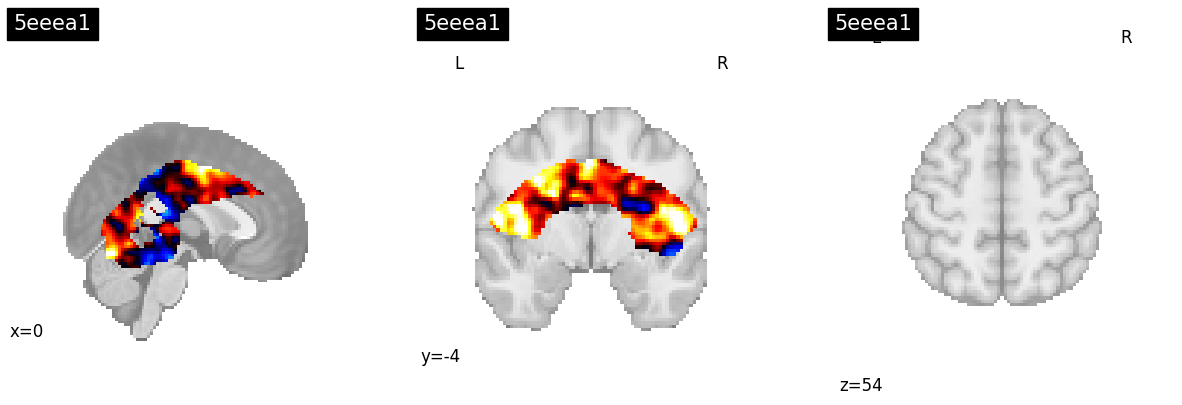

Cluster [11] - Antimedoid


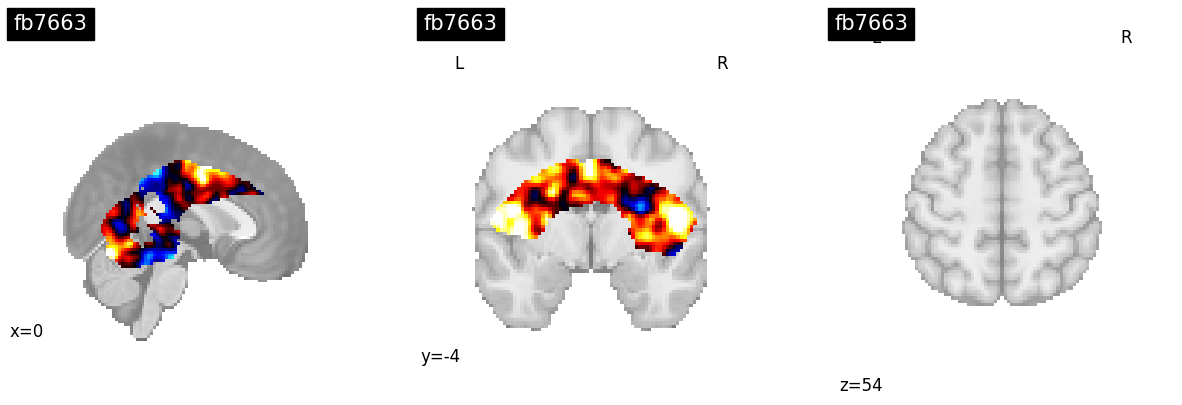

In [22]:
from plot_utils import plot_brain

threshold = 0.95
medoids = df_results.loc[df_results['threshold'] == threshold, 'medoids'].values[0]
medoids = {k: medoids[k] for k in sorted(medoids)}
antimedoids = df_results.loc[df_results['threshold'] == threshold, 'antimedoids'].values[0]
for key, value in medoids.items():
    print(f"Cluster [{key}] - Medoid [{value}]")
    img_path = os.path.join(result_path, value, 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)
    print(f"Cluster [{key}] - Antimedoid")
    img_path = os.path.join(result_path, antimedoids[key], 'spmT_0001.nii')
    plot_brain(img_path, coords, ref_path=None)

# Filter incorrect configs
- Cluster by t
- Display medoids
- Eliminate cluster by medoids

In [23]:
excluding_medoids = []

for key, value in medoids.items():
    if key not in [1, 3, 4]:
        excluding_medoids.append(value)

print(f"Excludes {len(excluding_medoids)} clusters")

ds, matrix, Z, clusters = clusterize_hierch(dataset, correlations, dataset['id'], None, corr_func, threshold)

print(f"Threshold = {threshold} - Clusters = {len(clusters.unique())}")

clusters_to_exclude = set()
for medoid in excluding_medoids:
    cluster = ds.loc[ds['id'] == medoid, 'cluster'].values
    if len(cluster) > 0:
        clusters_to_exclude.add(cluster[0])

acceptable_dataset = ds[~ds['cluster'].isin(clusters_to_exclude)]
acceptable_dataset = acceptable_dataset.drop(columns=['cluster'])
acceptable_dataset.to_csv(os.path.join(datadir, 'acceptable_dataset.csv'), index=False)
print(f"Acceptabes : {len(acceptable_dataset)}")

unacceptable_dataset = ds[ds['cluster'].isin(clusters_to_exclude)]
unacceptable_dataset = unacceptable_dataset.drop(columns=['cluster'])
unacceptable_dataset.to_csv(os.path.join(datadir, 'unacceptable_dataset.csv'), index=False) 
print(f"Unacceptabes : {len(unacceptable_dataset)}")

filtered_dataset = acceptable_dataset.copy()

Excludes 8 clusters
Threshold = 0.95 - Clusters = 11
Acceptabes : 380
Unacceptabes : 620


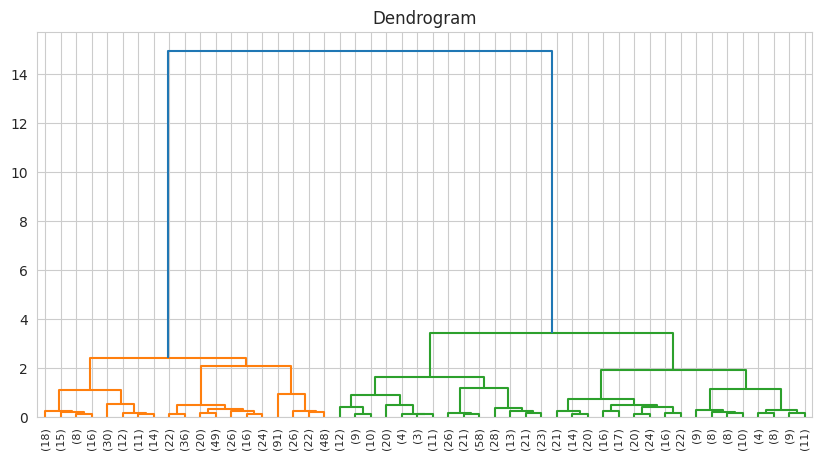

ValueError: could not convert string to float: '3c05066eec67a15033be163c0f9ff11b5c10fd45cd65ba4bee3ceb1d429624db'

In [24]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Plot the dendrogram (optional, for visualization)
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='lastp', p=50)  # Show last 50 merges
plt.title('Dendrogram')
plt.show()

# PCA
distance_matrix = 1 - matrix
pca = PCA(n_components=2)
pca_result = pca.fit_transform(dataset)
plt.figure(figsize=(10, 6))
sb.scatterplot(
    x=pca_result[:, 0], y=pca_result[:, 1],
    hue=clusters,
    palette='tab20',
    alpha=0.7
)
plt.title('PCA Plot of Clusters')
plt.show()

# t-SNE

tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(dataset)
print(len(tsne_result))

## Distribution from_ref for acceptable/unacceptable

{'min': np.float64(0.7747673542413108), 'max': np.float64(1.0), 'mean': np.float64(0.9024462918142214)}
{'min': np.float64(0.2186400252700563), 'max': np.float64(0.8697073974262888), 'mean': np.float64(0.3784460714759805)}


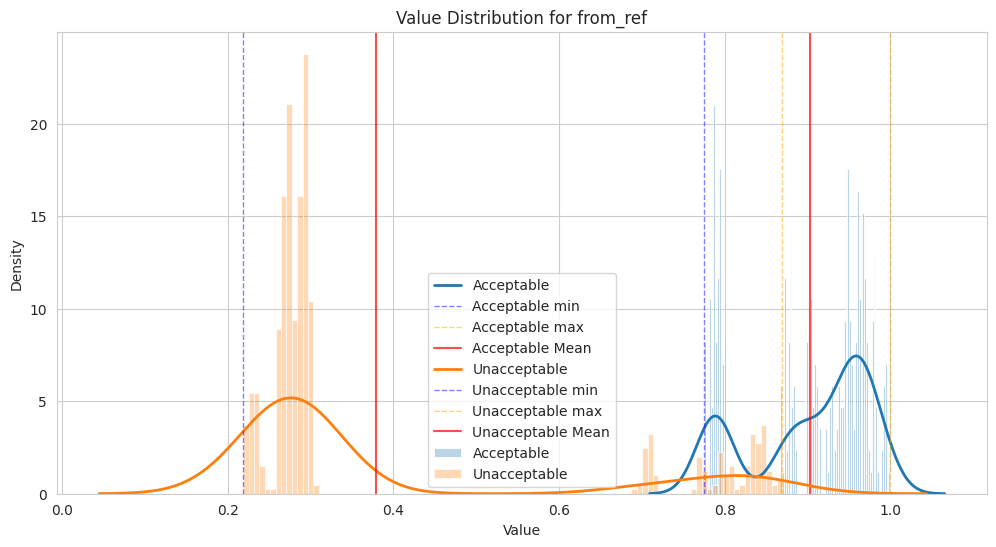

In [25]:
# Create a dictionary to loop over the datasets
datasets = {
    'Acceptable': acceptable_dataset,
    'Unacceptable': unacceptable_dataset
}

# Calculate min, max, and mean for each dataset
stats = {}
for label, df in datasets.items():
    stats[label] = {
        'min': df['from_ref'].min(),
        'max': df['from_ref'].max(),
        'mean': df['from_ref'].mean()
    }
    print(stats[label])

# Plot
plt.figure(figsize=(12, 6))
for label, df in datasets.items():
    sb.histplot(
        df['from_ref'],
        bins=100,
        alpha=0.3,
        label=label,
        kde=False,
        stat='density'
    )
    sb.kdeplot(
        df['from_ref'],
        label=label,
        linewidth=2
    )
    # Add vertical lines for min, max, and mean
    plt.axvline(stats[label]['min'], color='blue', linestyle='--', alpha=0.5, linewidth=1, label=f'{label} min')
    plt.axvline(stats[label]['max'], color='orange', linestyle='--', alpha=0.5, linewidth=1, label=f'{label} max')
    plt.axvline(stats[label]['mean'], color='red', linestyle='-', alpha=0.7, linewidth=1.5, label=f'{label} Mean')

plt.title('Value Distribution for from_ref')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

accuracy: 1.0 , recall: 1.0


/home/ymerel/tmp/ipykernel_16048/2666558622.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


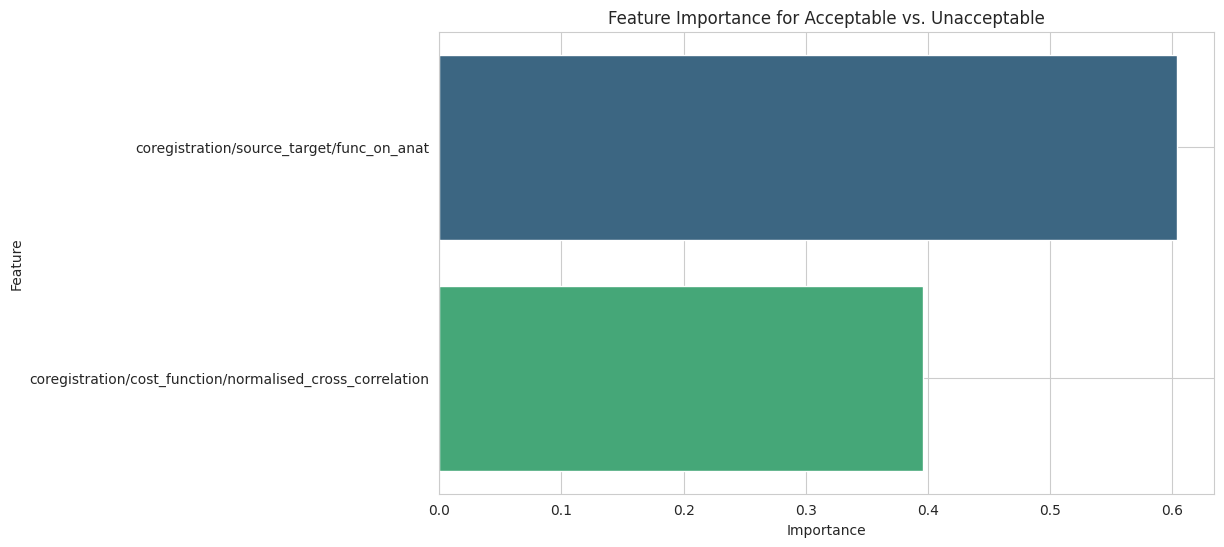

In [26]:
from sklearn import tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz


def analyze_feature_importance(acceptable, unacceptable, train_size=0.7):
    # Combine datasets and add a binary target column
    acceptable['target'] = 0  # 0 for acceptable
    unacceptable['target'] = 1  # 1 for unacceptable
    combined = pd.concat([acceptable, unacceptable])

    # Drop non-feature columns (e.g., 'id')
    ignored = [col for col in combined.columns if col.startswith('from_') or col in ['id', 'target']]
    features = combined.drop(columns=ignored).columns
    X = combined[features]
    y = combined['target']

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_size, random_state=42
    )

    # Train a Decision Tree classifier
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    print(f"accuracy: {report['accuracy']} , recall: {report['macro avg']['recall']}")

    # Extract feature importances
    importances = classifier.feature_importances_
    feat_importances = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    importances = classifier.feature_importances_
    feat_importances = dict()
    for i, feat in enumerate(features):
        if importances[i] > 0.0:
            feat_importances[feat] = importances[i]
    results['feature_importances'] = feat_importances
    
    dot_data = tree.export_graphviz(classifier, out_file=None,
     feature_names=X_train.columns.values,
     filled=True, rounded=True,
     special_characters=True,
     leaves_parallel=True, proportion=True)
    graph = graphviz.Source(dot_data)
    graph.render(f"unacceptable_vs_acceptable")
    
    return feat_importances

feat_importances_df = pd.DataFrame(
    list(analyze_feature_importance(acceptable_dataset, unacceptable_dataset).items()),
    columns=['Feature', 'Importance']
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')
plt.title('Feature Importance for Acceptable vs. Unacceptable')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True)
plt.show()



## [Filtered] Cluster by threshold

In [48]:
all_results = []

print(len(filtered_dataset))

thresholds = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    results = dict()
    results['threshold'] = threshold
    # cluster on whole dataset
    ds, matrix, Z, clusters =  clusterize_hierch(filtered_dataset, correlations, filtered_dataset['id'], None, corr_func, threshold)
    results['clusters'] = len(np.unique(clusters.values)) 
    
    distance_matrix = 1 - matrix
    densities = get_cluster_distance_densities(distance_matrix.values, clusters.values)
    results['mean_density'] = np.mean(list(densities.values()))
    results['cophenetic'] = get_cluster_cophenetic(Z, distance_matrix.values)
    results['silhouette'] = get_cluster_silhouette(distance_matrix.values, clusters.values)
    results['davies_bouldin'] = get_davies_bouldin(distance_matrix.values, clusters.values)
    results['inertia'] = get_cluster_inertia(distance_matrix.values, clusters.values)
    results['medoids'] = get_medoids(distance_matrix, clusters)
        
    # predict on 70 % train dataset
    merged_results = results | predict_clusters(filtered_dataset, correlations, None, corr_func, threshold, 0.7)
    all_results.append(merged_results)

df_by_thresh = pd.DataFrame(all_results)
df_results = df_by_thresh
df_by_thresh.head(20)

380


,threshold,clusters,mean_density,cophenetic,silhouette,davies_bouldin,inertia,medoids,train_size,accuracy,recall,decision_tree,feature_importances
0,0.05,25,0.010297,0.821041,0.549002,0.763234,0.740619,{21: '885e713775f3e76f5757003b0aa28bc3274ac668...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.0739...
1,0.10,14,0.014206,0.821041,0.508822,0.862565,2.778085,{9: 'cee82033109101f0170577853fd8d6b0bd38297a3...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.1157...
2,0.15,10,0.017759,0.821041,0.606130,1.006679,6.788047,{7: 'cee82033109101f0170577853fd8d6b0bd38297a3...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2270...
3,0.20,8,0.020277,0.821041,0.596820,0.928996,11.478293,{6: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2452...
4,0.25,6,0.024802,0.821041,0.552630,0.941538,20.556667,{5: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2613...
5,0.30,5,0.027479,0.821041,0.585817,0.916877,29.450090,{4: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2784...
6,0.35,5,0.027479,0.821041,0.585817,0.916877,29.450090,{4: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors': 0.2784...
7,0.40,4,0.029449,0.821041,0.567574,0.775768,56.855028,{3: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
8,0.45,4,0.029449,0.821041,0.567574,0.775768,56.855028,{3: '90857a6b00cbc337213595e2da1761df8e6b10f20...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...
9,0.50,3,0.033738,0.821041,0.643223,0.421495,125.316220,{2: '71e407ecf3e4c3b45941b22394d693b9dbbaa03f7...,0.7,1.0,1.0,"digraph Tree {\nnode [shape=box, style=""filled...",{'signal_modeling/nuisance_regressors/motion':...


## [Filtered] Print all metrics
- Cophenetic correlation: > 0.75 = good ; < 0.75 = poor
- Silhouette score: -1 = worst ; 1 = best
- Davies-Bouldin index: < 1 = good
- Inertia: lower = tighter

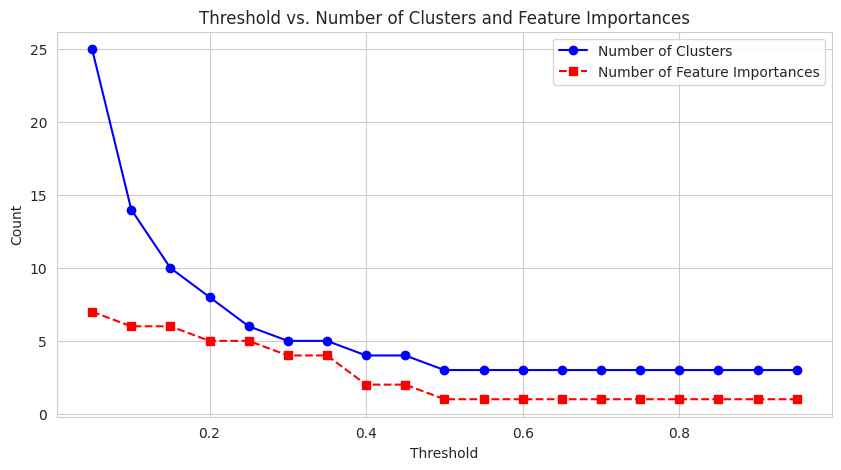

In [44]:
import matplotlib.pyplot as plt

# Add a new column to count the number of feature importances for each threshold
df_results['num_feature_importances'] = df_results['feature_importances'].apply(lambda x: len(x))

# Plot threshold vs. number of clusters
plt.figure(figsize=(10, 5))
plt.plot(df_results['threshold'], df_results['clusters'], marker='o', linestyle='-', color='b', label='Number of Clusters')

# Plot threshold vs. number of feature importances
plt.plot(df_results['threshold'], df_results['num_feature_importances'], marker='s', linestyle='--', color='r', label='Number of Feature Importances')

plt.title('Threshold vs. Number of Clusters and Feature Importances')
plt.xlabel('Threshold')
plt.ylabel('Count')
plt.grid(True)
plt.legend()
plt.show()

# [Filtered] Feature importances

/home/ymerel/tmp/ipykernel_16048/4008954553.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')


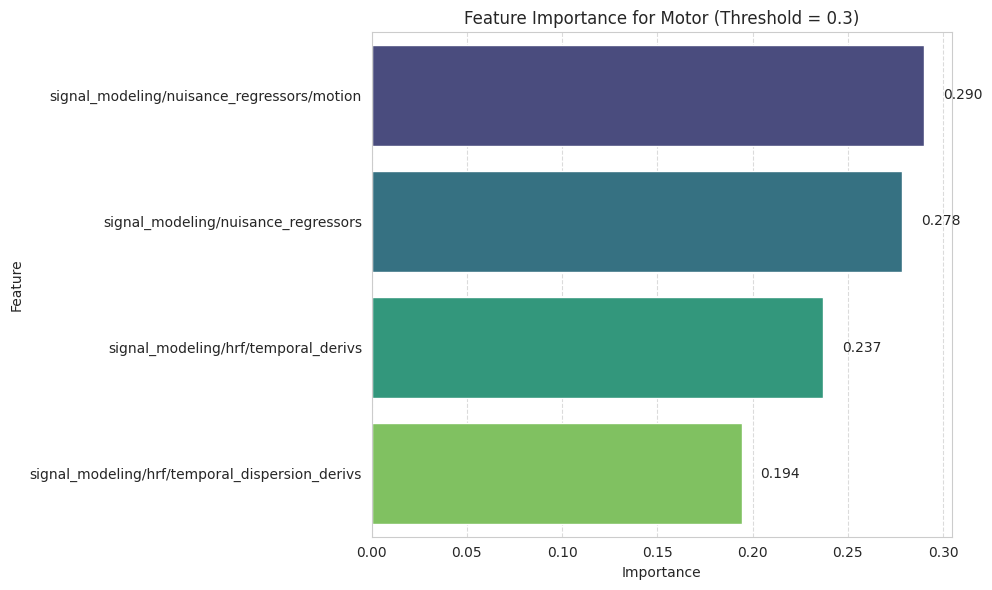

In [49]:
import pandas as pd1
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

threshold=0.3

# Extract feature importances for threshold == 0.10
feat_importances_dict = df_results.loc[df_results['threshold'] == threshold, 'feature_importances'].values[0]

# Convert to DataFrame and sort by importance (descending)
feat_importances_df = pd.DataFrame(
    list(feat_importances_dict.items()),
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)

# Render decision tree
graph = graphviz.Source(df_results.loc[df_results['threshold'] == threshold, 'decision_tree'].values[0])
graph.render(f"motor")

# Plot feature importances
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=feat_importances_df, palette='viridis')

# Display the importance values on the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # x position (slightly right of the bar)
             p.get_y() + p.get_height() / 2,  # y position (center of the bar)
             f'{width:.3f}',  # text to display (formatted to 3 decimal places)
             ha='left',  # horizontal alignment
             va='center')  # vertical alignment

plt.title(f'Feature Importance for Motor (Threshold = {threshold})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [47]:
import pydot

# Extract the DOT source from the graphviz.Source object
dot_source = graph.source
# Load the DOT source into pydot
graph_pydot = pydot.graph_from_dot_data(dot_source)[0]
for node in graph_pydot.get_nodes():
    print(node.get_sequence())
    node.get_port()
for edge in graph_pydot.get_edges():
    print(edge)

1
2
3
4
5
7
9
11
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"];
1 -> 2;
1 -> 3;
0 -> 4 [labeldistance=2.5, labelangle="-45", headlabel="False"];
